# Credit Risk Classification

## Olivia Wang
#### Packages: sklearn, matplotlib, pandas, numpy
#### Source: https://www.openml.org/d/31

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as knn
import random
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dataset_31_credit-g.csv')
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


### 1.1 Determine which features are continuous and which are categorical.

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checking_status           1000 non-null object
duration                  1000 non-null int64
credit_history            1000 non-null object
purpose                   1000 non-null object
credit_amount             1000 non-null int64
savings_status            1000 non-null object
employment                1000 non-null object
installment_commitment    1000 non-null int64
personal_status           1000 non-null object
other_parties             1000 non-null object
residence_since           1000 non-null int64
property_magnitude        1000 non-null object
age                       1000 non-null int64
other_payment_plans       1000 non-null object
housing                   1000 non-null object
existing_credits          1000 non-null int64
job                       1000 non-null object
num_dependents            1000 non-null int64
own_telephone             1000 non-null object
foreign_

In [4]:
categorical_var = []
continuous_var = []
for column in df:
    if column != 'class':
        if df[column].dtype == 'int64':
            continuous_var.append(column)
        else:
            categorical_var.append(column)
            
print(f'categorical variables: {categorical_var}')
print(f'continuous variables: {continuous_var}')

categorical variables: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']
continuous variables: ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']


### 1.2 Visualize the univariate distribution of each continuous feature, and the distribution of the target.

In [5]:
to_plot = continuous_var
to_plot.append('class')

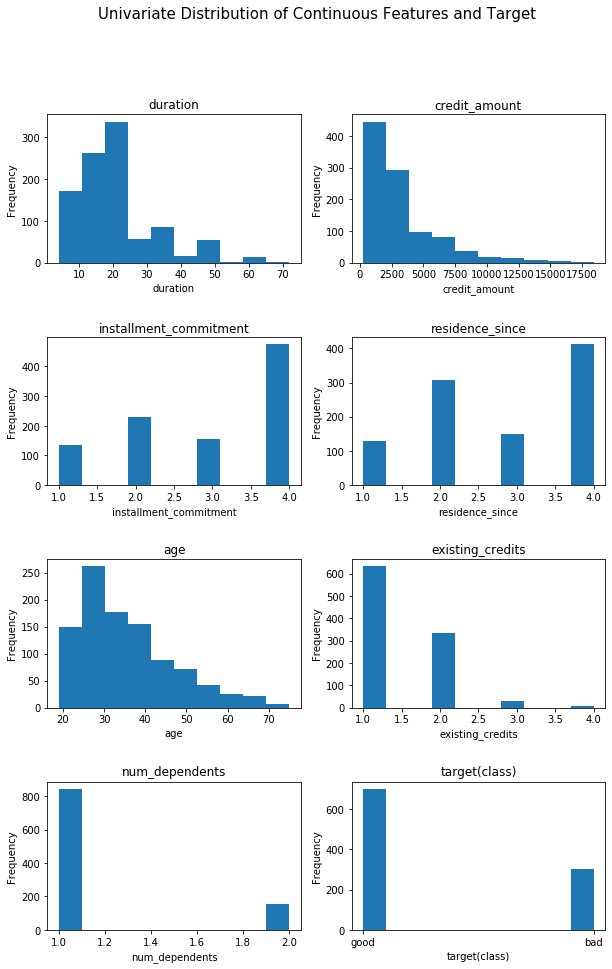

In [6]:
width = 2
fig, ax = plt.subplots(4,width, figsize = (10, 15))
fig.suptitle('Univariate Distribution of Continuous Features and Target', fontsize = 15)
fig.subplots_adjust(hspace=0.5)
for row in range(len(ax)):
    for column in range(len(ax[0])):
        i = width*row + column
        ax[row,column].hist(df[to_plot[i]])
        if to_plot[i] != 'class':
            ax[row,column].title.set_text(to_plot[i])
            ax[row,column].set_xlabel(to_plot[i])
            ax[row,column].set_ylabel('Frequency')
        else:
            ax[row,column].title.set_text('target(class)')
            ax[row,column].set_xlabel('target(class)')
            ax[row,column].set_ylabel('Frequency')
plt.show()

### 1.3 Split data into training and test set. 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:,'checking_status':'foreign_worker'], df['class'], random_state=42)

#### Preprocess the data without using a pipeline and evaluate an initial LogisticRegression model with an training/validation split.

In [8]:
X_train_encoded = pd.get_dummies(data=X_train, columns=['checking_status', 'credit_history', 'purpose', 
                                 'savings_status', 'employment', 'personal_status', 
                                 'other_parties', 'property_magnitude', 'other_payment_plans', 
                                 'housing', 'job', 'own_telephone', 'foreign_worker'])

In [9]:
lr = LogisticRegression().fit(X_train_encoded,y_train)
scores = np.mean(cross_val_score(LogisticRegression(),X_train_encoded,y_train,cv=5))
print(f'mean cv accuracy using lr: {scores:0.3f}')

mean cv accuracy using lr: 0.737


#### Use ColumnTransformer and pipeline to encode categorical variables. 

In [10]:
categories = X_train.dtypes == "object"
preprocess = make_column_transformer(
    (StandardScaler(), ~categories),
    (OneHotEncoder(), categories))

In [11]:
# Logistic Regression
lr_pip = make_pipeline(preprocess,LogisticRegression())
scores = np.mean(cross_val_score(lr_pip,X_train,y_train))
print(f'mean cv accuracy using lr: {scores:0.3f}')

# Linear SVC
svm_pip = make_pipeline(preprocess, svm.LinearSVC())
scores = np.mean(cross_val_score(svm_pip,X_train,y_train))
print(f'mean cv accuracy using linear SVM: {scores:0.3f}')

# KNN
knn_pip = make_pipeline(preprocess, knn())
scores = np.mean(cross_val_score(knn_pip,X_train,y_train))
print(f'mean cv accuracy using KNN: {scores:0.3f}')

mean cv accuracy using lr: 0.729
mean cv accuracy using linear SVM: 0.728
mean cv accuracy using KNN: 0.731


 #### How does scaling the continuous features with StandardScaler influence the results?

#### We can see that the mean cross validation accuracy of the three models do not differ drastically. That of Logistic Regression and Linear SVM are the most similar, with that of KNN slightly lower. 
#### Scaling the continuous features with StandardScaler did not influence the cross validation accuracy much. In fact, it made that of Logistic Regression slighly lower. However, it is hard to tell from the random sample.


### 1.4 Tune the parameters using GridSearchCV.

In [12]:
pipe = Pipeline([('scaler', preprocess),
                 ('regressor', LogisticRegression())])

param_grid = [{'regressor': [LogisticRegression()],
               'regressor__C': [0.001, 0.01, 0.1, 1, 10]},
              {'regressor': [svm.LinearSVC()],
               'regressor__C': [0.001, 0.01, 0.1, 1, 10]},
              {'regressor': [knn()],
               'regressor__n_neighbors': [2,4,6,8,10]}
             ]
grid = GridSearchCV(pipe, param_grid, return_train_score=True)
grid.fit(X_train, y_train)
print(grid.score(X_test, y_test))
print(grid.best_params_)
print(grid.cv_results_['mean_test_score'])

0.768
{'regressor': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'regressor__C': 0.1}
[0.696      0.70666667 0.736      0.72933333 0.728      0.704
 0.73333333 0.72933333 0.728      0.728      0.61466667 0.712
 0.72533333 0.724      0.73466667]


#### Do the results improve? 
#### We can see that tuning the parameters using GridSearchCV did improve the results slightly. Evaluating the best model on the test set, we can see that the cross validation score improved by about 0.04 using Logistic Regression(C=0.1).

In [13]:
results_grid = pd.DataFrame.from_dict(grid.cv_results_)
results_grid

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,param_regressor__C,param_regressor__n_neighbors,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.013836,0.002236,0.005548,0.001295,"LogisticRegression(C=0.1, class_weight=None, d...",0.001,NaN,"{'regressor': LogisticRegression(C=0.1, class_...",0.700000,0.700000,...,0.696000,0.003266,14,0.695000,0.695000,0.696667,0.696667,0.696667,0.696000,0.000816
1,0.013185,0.000194,0.004895,0.000411,"LogisticRegression(C=0.1, class_weight=None, d...",0.01,NaN,"{'regressor': LogisticRegression(C=0.1, class_...",0.713333,0.706667,...,0.706667,0.013333,12,0.711667,0.728333,0.733333,0.708333,0.718333,0.720000,0.009545
2,0.017759,0.003632,0.005009,0.000763,"LogisticRegression(C=0.1, class_weight=None, d...",0.1,NaN,"{'regressor': LogisticRegression(C=0.1, class_...",0.793333,0.720000,...,0.736000,0.049639,1,0.773333,0.796667,0.801667,0.761667,0.775000,0.781667,0.015092
3,0.023469,0.001245,0.004816,0.000115,"LogisticRegression(C=0.1, class_weight=None, d...",1,NaN,"{'regressor': LogisticRegression(C=0.1, class_...",0.760000,0.733333,...,0.729333,0.054095,5,0.791667,0.805000,0.813333,0.781667,0.776667,0.793667,0.013800
4,0.028197,0.000481,0.004700,0.000048,"LogisticRegression(C=0.1, class_weight=None, d...",10,NaN,"{'regressor': LogisticRegression(C=0.1, class_...",0.753333,0.726667,...,0.728000,0.050315,6,0.790000,0.803333,0.815000,0.786667,0.775000,0.794000,0.013848
5,0.010604,0.000052,0.004569,0.000031,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.001,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.706667,0.706667,...,0.704000,0.014967,13,0.715000,0.725000,0.728333,0.710000,0.720000,0.719667,0.006616
6,0.010818,0.000104,0.004698,0.000238,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.01,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.786667,0.720000,...,0.733333,0.044821,3,0.770000,0.790000,0.801667,0.758333,0.768333,0.777667,0.015797
7,0.014065,0.002053,0.005701,0.002265,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.1,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.766667,0.726667,...,0.729333,0.057596,4,0.790000,0.795000,0.813333,0.776667,0.786667,0.792333,0.012092
8,0.045825,0.011313,0.005269,0.001006,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.766667,0.726667,...,0.728000,0.054715,6,0.790000,0.805000,0.816667,0.785000,0.783333,0.796000,0.012850
9,0.042931,0.000858,0.004692,0.000130,"LinearSVC(C=1.0, class_weight=None, dual=True,...",10,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.766667,0.740000,...,0.728000,0.047777,6,0.786667,0.801667,0.811667,0.775000,0.785000,0.792000,0.013013


#### Visualize the performance as function of the parameters for all three models.

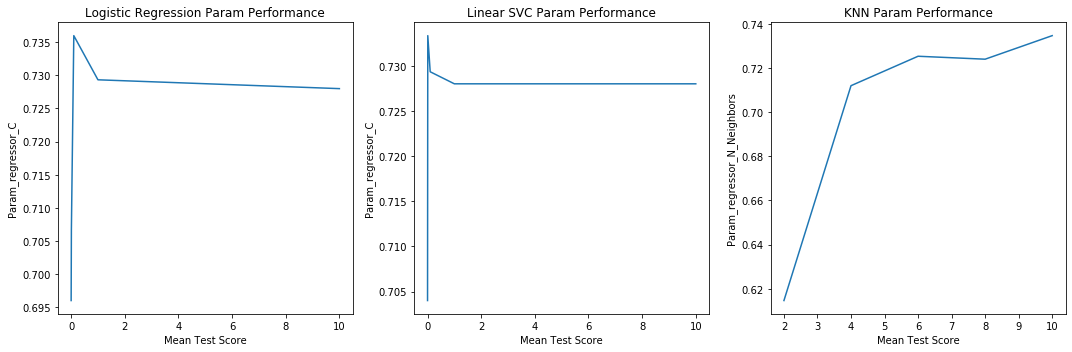

In [14]:
fig, ax = plt.subplots(1,3, figsize = (15, 5))
fig.subplots_adjust(hspace=0.5)
ax[0].plot('param_regressor__C', 'mean_test_score', data = results_grid[0:5])
ax[0].title.set_text('Logistic Regression Param Performance')
ax[0].set_xlabel('Mean Test Score')
ax[0].set_ylabel('Param_regressor_C')
ax[1].plot('param_regressor__C', 'mean_test_score', data = results_grid[5:10])
ax[1].title.set_text('Linear SVC Param Performance')
ax[1].set_xlabel('Mean Test Score')
ax[1].set_ylabel('Param_regressor_C')
ax[2].plot('param_regressor__n_neighbors', 'mean_test_score', data = results_grid[10:])
ax[2].title.set_text('KNN Param Performance')
ax[2].set_xlabel('Mean Test Score')
ax[2].set_ylabel('Param_regressor_N_Neighbors');
plt.tight_layout()
plt.show()

### 1.5 Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. 

In [15]:
# Train_test_split with shuffling
kf = KFold(n_splits = 5, shuffle = True)
grid_1 = GridSearchCV(pipe, param_grid, return_train_score=True, cv = kf)
grid_1.fit(X_train, y_train)
print(grid_1.score(X_test, y_test))
print(grid_1.best_params_)
print(grid_1.cv_results_['mean_test_score'])

0.768
{'regressor': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'regressor__C': 1}
[0.696      0.70933333 0.744      0.74933333 0.73866667 0.71466667
 0.74666667 0.748      0.74666667 0.74533333 0.64133333 0.71866667
 0.73066667 0.744      0.736     ]


#### Do the parameters that are found change? 
#### Changing the cross-validation strategy from 'stratified k-fold' to 'kfold' with shuffling changed the best param from Logistic Regression to Linear SVC(C = 0.01). However, the mean test scores did not vary much.

In [16]:
results_grid_1 = pd.DataFrame.from_dict(grid_1.cv_results_)
results_grid_1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,param_regressor__C,param_regressor__n_neighbors,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.014011,0.002695,0.005063,0.000850,"LogisticRegression(C=1, class_weight=None, dua...",0.001,NaN,"{'regressor': LogisticRegression(C=1, class_we...",0.700000,0.686667,...,0.696000,0.019596,14,0.695000,0.698333,0.688333,0.695000,0.703333,0.696000,0.004899
1,0.017972,0.009024,0.005656,0.001896,"LogisticRegression(C=1, class_weight=None, dua...",0.01,NaN,"{'regressor': LogisticRegression(C=1, class_we...",0.713333,0.720000,...,0.709333,0.022151,13,0.715000,0.716667,0.710000,0.725000,0.725000,0.718333,0.005869
2,0.017166,0.002300,0.004785,0.000359,"LogisticRegression(C=1, class_weight=None, dua...",0.1,NaN,"{'regressor': LogisticRegression(C=1, class_we...",0.753333,0.733333,...,0.744000,0.014360,6,0.781667,0.786667,0.766667,0.786667,0.790000,0.782333,0.008273
3,0.022704,0.000494,0.004684,0.000073,"LogisticRegression(C=1, class_weight=None, dua...",1,NaN,"{'regressor': LogisticRegression(C=1, class_we...",0.753333,0.773333,...,0.749333,0.013728,1,0.783333,0.796667,0.771667,0.791667,0.785000,0.785667,0.008472
4,0.027668,0.000273,0.004782,0.000094,"LogisticRegression(C=1, class_weight=None, dua...",10,NaN,"{'regressor': LogisticRegression(C=1, class_we...",0.753333,0.773333,...,0.738667,0.021250,8,0.783333,0.800000,0.780000,0.801667,0.785000,0.790000,0.009006
5,0.010629,0.000046,0.004595,0.000075,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.001,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.726667,0.720000,...,0.714667,0.024368,12,0.720000,0.720000,0.715000,0.726667,0.720000,0.720333,0.003712
6,0.026000,0.030390,0.004706,0.000095,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.01,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.746667,0.733333,...,0.746667,0.014606,3,0.781667,0.791667,0.765000,0.786667,0.791667,0.783333,0.009888
7,0.014039,0.001897,0.004712,0.000190,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.1,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.753333,0.773333,...,0.748000,0.015434,2,0.785000,0.800000,0.776667,0.790000,0.791667,0.788667,0.007703
8,0.039189,0.002464,0.004693,0.000036,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.753333,0.766667,...,0.746667,0.012649,3,0.775000,0.795000,0.783333,0.795000,0.788333,0.787333,0.007572
9,0.042692,0.000431,0.004679,0.000047,"LinearSVC(C=1.0, class_weight=None, dual=True,...",10,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.746667,0.766667,...,0.745333,0.012220,5,0.781667,0.790000,0.791667,0.795000,0.778333,0.787333,0.006289


In [17]:
# Train_test_split with random.seed() shuffling
kf_r = KFold(n_splits = 5, shuffle = True, random_state = random.seed(10))
grid_2 = GridSearchCV(pipe, param_grid, return_train_score=True, cv = kf_r)
grid_2.fit(X_train, y_train)
print(grid_2.score(X_test, y_test))
print(grid_2.best_params_)
print(grid_2.cv_results_['mean_test_score'])

0.768
{'regressor': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'regressor__C': 0.1}
[0.696      0.70933333 0.75466667 0.74133333 0.73333333 0.70933333
 0.748      0.736      0.73466667 0.74133333 0.632      0.7
 0.71733333 0.71733333 0.724     ]


#### Changing the random seed of shuffling also did not alter the mean test scores much. However, it changed the best parameter back to Logistic Regression (C=0.1)

In [18]:
results_grid_2 = pd.DataFrame.from_dict(grid_2.cv_results_)
results_grid_2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,param_regressor__C,param_regressor__n_neighbors,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.016144,0.002820,0.005107,0.000617,"LogisticRegression(C=0.1, class_weight=None, d...",0.001,NaN,"{'regressor': LogisticRegression(C=0.1, class_...",0.673333,0.713333,...,0.696000,0.018667,14,0.701667,0.691667,0.693333,0.701667,0.691667,0.696000,0.004667
1,0.013415,0.000629,0.004670,0.000103,"LogisticRegression(C=0.1, class_weight=None, d...",0.01,NaN,"{'regressor': LogisticRegression(C=0.1, class_...",0.680000,0.746667,...,0.709333,0.037142,11,0.716667,0.706667,0.713333,0.741667,0.715000,0.718667,0.011991
2,0.029125,0.024509,0.005077,0.000721,"LogisticRegression(C=0.1, class_weight=None, d...",0.1,NaN,"{'regressor': LogisticRegression(C=0.1, class_...",0.693333,0.773333,...,0.754667,0.038505,1,0.785000,0.760000,0.783333,0.790000,0.778333,0.779333,0.010360
3,0.022701,0.000424,0.004849,0.000284,"LogisticRegression(C=0.1, class_weight=None, d...",1,NaN,"{'regressor': LogisticRegression(C=0.1, class_...",0.693333,0.753333,...,0.741333,0.035125,3,0.806667,0.775000,0.788333,0.803333,0.785000,0.791667,0.011785
4,0.027585,0.000231,0.004682,0.000049,"LogisticRegression(C=0.1, class_weight=None, d...",10,NaN,"{'regressor': LogisticRegression(C=0.1, class_...",0.680000,0.753333,...,0.733333,0.038873,7,0.805000,0.780000,0.785000,0.795000,0.778333,0.788667,0.010022
5,0.010688,0.000099,0.004578,0.000028,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.001,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.680000,0.753333,...,0.709333,0.037381,11,0.723333,0.706667,0.708333,0.738333,0.720000,0.719333,0.011479
6,0.017358,0.013052,0.004705,0.000276,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.01,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.693333,0.780000,...,0.748000,0.037094,2,0.785000,0.758333,0.773333,0.790000,0.781667,0.777667,0.011086
7,0.013154,0.000217,0.004612,0.000086,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.1,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.680000,0.766667,...,0.736000,0.041009,5,0.803333,0.775000,0.786667,0.793333,0.783333,0.788333,0.009545
8,0.043119,0.007019,0.005577,0.001775,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.686667,0.760000,...,0.734667,0.036612,6,0.798333,0.780000,0.793333,0.793333,0.783333,0.789667,0.006864
9,0.045250,0.004071,0.005063,0.000509,"LinearSVC(C=1.0, class_weight=None, dual=True,...",10,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.693333,0.766667,...,0.741333,0.042458,4,0.795000,0.766667,0.785000,0.796667,0.775000,0.783667,0.011518


#### Do the parameters change if you change the random seed of the shuffling? Or if you change the random state of the split into training and test data?

In [19]:
# Train_test_split with randome_state
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:,'checking_status':'foreign_worker'], df['class'], random_state=random.seed(10))
grid_3 = GridSearchCV(pipe, param_grid, return_train_score=True)
grid_3.fit(X_train, y_train)
print(grid_3.score(X_test, y_test))
print(grid_3.best_params_)
print(grid_3.cv_results_['mean_test_score'])

0.72
{'regressor': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'regressor__C': 0.1}
[0.70533333 0.724      0.764      0.75466667 0.74933333 0.724
 0.75866667 0.76266667 0.752      0.74666667 0.65866667 0.70933333
 0.72133333 0.744      0.73066667]


In [26]:
results_grid_3 = pd.DataFrame.from_dict(grid_3.cv_results_)
results_grid_3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,param_regressor__C,param_regressor__n_neighbors,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.014173,0.001707,0.005106,0.000478,"LogisticRegression(C=0.1, class_weight=None, d...",0.001,NaN,"{'regressor': LogisticRegression(C=0.1, class_...",0.706667,0.706667,...,0.705333,0.002667,14,0.705000,0.705000,0.705000,0.705000,0.706667,0.705333,0.000667
1,0.012876,0.000153,0.004598,0.000016,"LogisticRegression(C=0.1, class_weight=None, d...",0.01,NaN,"{'regressor': LogisticRegression(C=0.1, class_...",0.706667,0.746667,...,0.724000,0.013064,10,0.736667,0.725000,0.728333,0.721667,0.733333,0.729000,0.005437
2,0.015999,0.000468,0.004642,0.000085,"LogisticRegression(C=0.1, class_weight=None, d...",0.1,NaN,"{'regressor': LogisticRegression(C=0.1, class_...",0.786667,0.780000,...,0.764000,0.018667,1,0.800000,0.790000,0.816667,0.805000,0.803333,0.803000,0.008589
3,0.023104,0.000779,0.004896,0.000403,"LogisticRegression(C=0.1, class_weight=None, d...",1,NaN,"{'regressor': LogisticRegression(C=0.1, class_...",0.760000,0.780000,...,0.754667,0.015434,4,0.806667,0.798333,0.808333,0.811667,0.811667,0.807333,0.004899
4,0.029961,0.004718,0.005356,0.001329,"LogisticRegression(C=0.1, class_weight=None, d...",10,NaN,"{'regressor': LogisticRegression(C=0.1, class_...",0.760000,0.766667,...,0.749333,0.016111,6,0.808333,0.798333,0.803333,0.801667,0.805000,0.803333,0.003333
5,0.011321,0.001275,0.005055,0.000753,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.001,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.700000,0.746667,...,0.724000,0.014967,10,0.728333,0.725000,0.731667,0.723333,0.738333,0.729333,0.005333
6,0.010798,0.000046,0.004579,0.000023,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.01,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.760000,0.800000,...,0.758667,0.025438,3,0.800000,0.788333,0.818333,0.803333,0.798333,0.801667,0.009718
7,0.014785,0.003074,0.005071,0.000771,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.1,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.766667,0.800000,...,0.762667,0.021746,2,0.805000,0.800000,0.811667,0.810000,0.815000,0.808333,0.005270
8,0.037156,0.003122,0.004685,0.000199,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.746667,0.780000,...,0.752000,0.018571,5,0.801667,0.801667,0.806667,0.800000,0.805000,0.803000,0.002449
9,0.050873,0.017532,0.004780,0.000149,"LinearSVC(C=1.0, class_weight=None, dual=True,...",10,NaN,"{'regressor': LinearSVC(C=1.0, class_weight=No...",0.720000,0.793333,...,0.746667,0.032387,7,0.788333,0.800000,0.808333,0.791667,0.798333,0.797333,0.006960


#### Changing the randome state of train test split improved the test score by about 0.02, and it changed the best parameter to LinearSVC(C=0.01). However, the mean test scores did not alter much

### 1.6 Visualize the 20 most important coefficients for LogisticRegression and Linear Support Vector Machines using hyper-parameters that performed well in the grid-search.

In [20]:
pipe_lr = Pipeline([("Preprocessor", preprocess),
                   ("scaler", LogisticRegression(C = 0.01))]).fit(X_train, y_train)
model_lr = pipe_lr[-1].coef_[0]
best_coeff_lr = np.argpartition(abs(model_lr), -20)[-20:]
print(best_coeff_lr)


[45 47 58 57 48 52 39 33 18  7 51 30  1 28 17 12 10  8  2  0]


In [21]:
categorical = X_train.dtypes == 'object'
col_con = X_train[X_train.columns[~categorical]].columns

col_cat = pipe_lr.named_steps['Preprocessor'].transformers_[1][1].get_feature_names()

all_column_names = np.array(list(col_con) + list(col_cat))

Text(0.5, 0, 'Log Reg Coefficients')

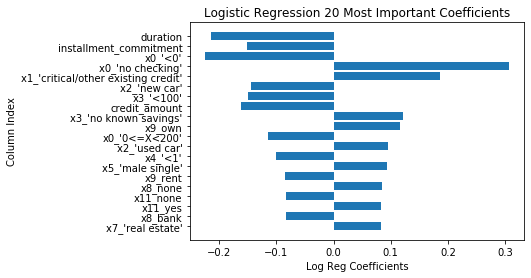

In [22]:
ax = plt.barh(all_column_names[best_coeff_lr], model_lr[best_coeff_lr])
plt.title('Logistic Regression 20 Most Important Coefficients')
plt.ylabel('Column Index')
plt.xlabel('Log Reg Coefficients')

In [23]:
pipe_svm = Pipeline([("Preprocessor", preprocess),
                     ("scaler",svm.LinearSVC(C = 0.1))]).fit(X_train, y_train)
model_svm = pipe_svm[-1].coef_[0]
best_coeff_svm = np.argpartition(abs(model_svm), -20)[-20:]
print(best_coeff_svm)

[28 39 15  1 58 32 20  9 60 41 40 22 18 17 12 11 10  8 59 30]


In [24]:
categorical = X_train.dtypes == 'object'
col_con = X_train[X_train.columns[~categorical]].columns

col_cat = pipe_svm.named_steps['Preprocessor'].transformers_[1][1].get_feature_names()

all_column_names = np.array(list(col_con) + list(col_cat))

Text(0.5, 0, 'LinearSVC Coefficients')

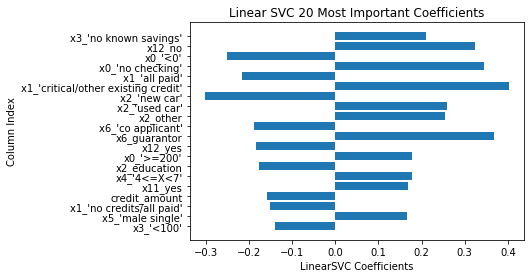

In [25]:
ax = plt.barh(all_column_names[best_coeff_svm], model_svm[best_coeff_svm])
plt.title('Linear SVC 20 Most Important Coefficients')
plt.ylabel('Column Index')
plt.xlabel('LinearSVC Coefficients')